## **1. 라이브러리 및 데이터 불러오기**

In [33]:
#기본 라이브러리
import numpy as np
import pandas as pd
import os

#시각화 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#그래프 스타일 서식 지정
plt.style.use('default')
#그래프 한글 폰트
from matplotlib import font_manager, rc
plt.rc("font", family = "Malgun Gothic")
plt.rc("axes", unicode_minus = False)

#사이킷런
from sklearn.datasets import *
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, RocCurveDisplay
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive/')
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/data/')



card_df = pd.read_csv('creditcard.csv')
card_df.head(10)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


- V1~V28는 차원축소(PCA)로 얻어진 결과, Time(시간), Amount(금액), Class(0: 사기X, 1: 사기!!)

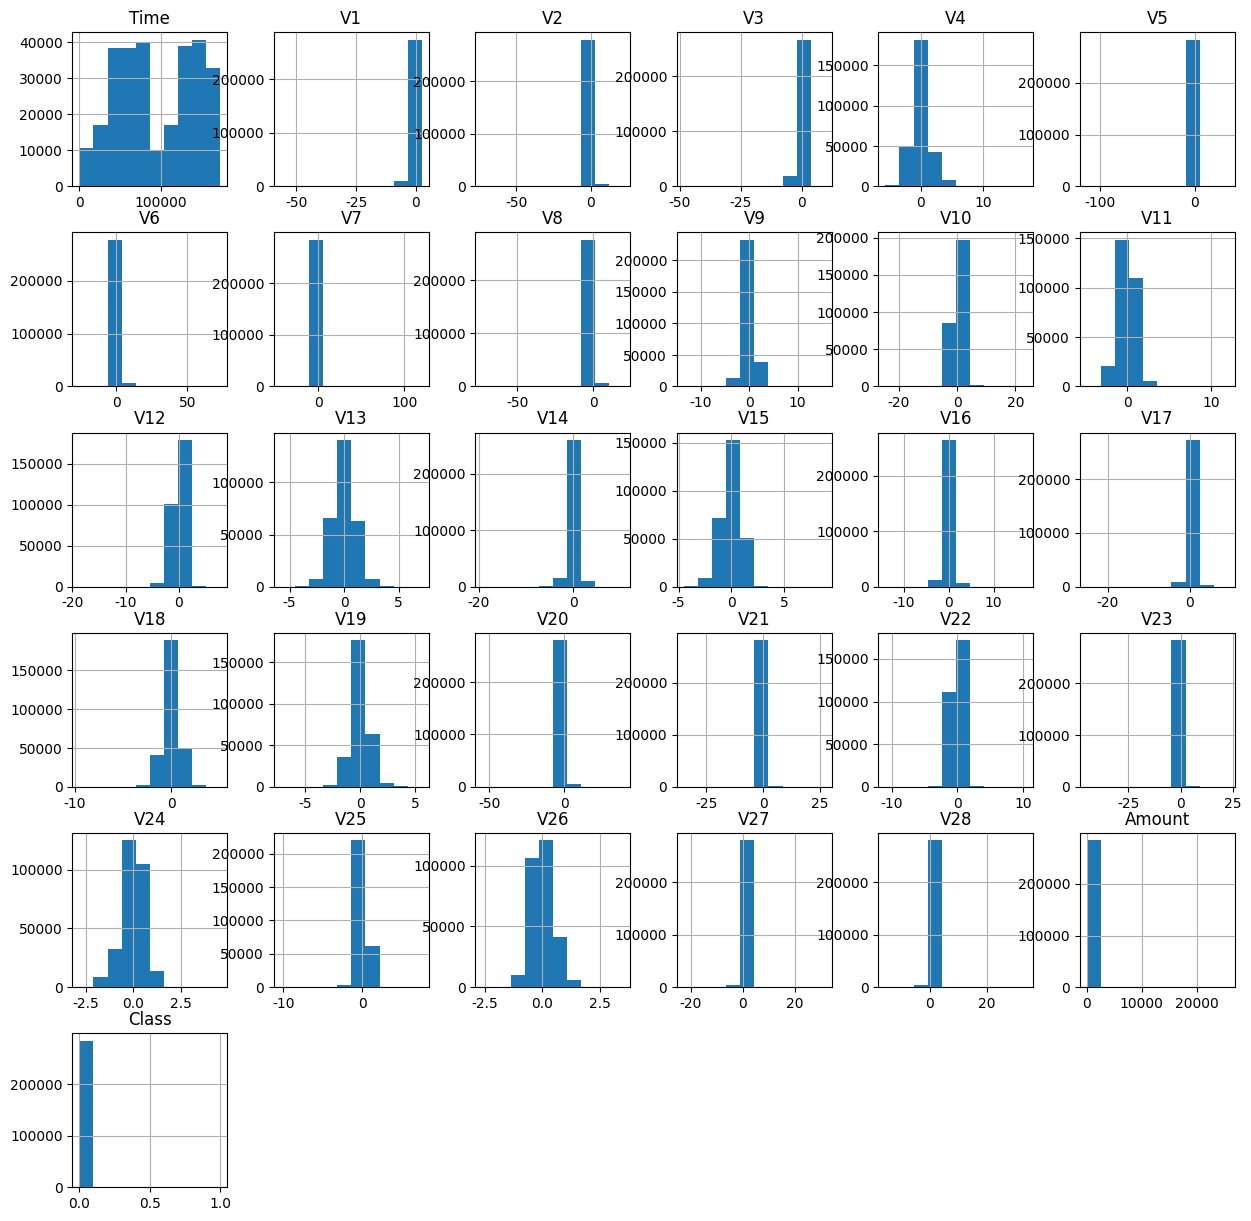

In [34]:
card_df.hist(figsize=(15,15))
plt.show()

In [35]:
# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    return df_copy

# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    x_features = df_copy.drop(["Class"], axis=1)
    y_target = df_copy.iloc[:, -1]
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

In [36]:
# value_counts() 
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [37]:
# value_counts(1)로 데이터 비율 확인
y_train.value_counts(1)*100

0    99.827451
1     0.172549
Name: Class, dtype: float64

- class 1이 0.17%로 심각한 불균형 데이터

## **2. 분류 모델**

In [67]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.

from sklearn.metrics import classification_report
import time

def get_model_train_eval(model, x_train, x_test, y_train, y_test):
    print('model :', model)
    # 시작 시간 측정
    start = time.time() 

    # 모델
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    pred_proba = model.predict_proba(x_test)[:, 1]
    
    # confusion matrix
    print(pd.crosstab(y_test, pred, rownames=['pred'], colnames=['real'])) 
    
    # classification report
    print(classification_report(y_test, pred)) 
    
    # AUC 산출 (Positive Label = 1)
    auc = roc_auc_score(y_test, pred_proba)

    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.plot( [0,1], [0,1], '--' )
    plt.title( 'ROC curve' )
    plt.legend( labels = ['AUC = %.4f' % auc], loc = 'lower right' )
    plt.show()

    # 끝 시간 측정
    end = time.time() 

    # 끝-시작 시간 print
    print('시간 :',end-start,'sec') 

model : XGBClassifier()
real      0    1
pred            
0     85284   11
1        41  107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.72      0.80       148

    accuracy                           1.00     85443
   macro avg       0.95      0.86      0.90     85443
weighted avg       1.00      1.00      1.00     85443



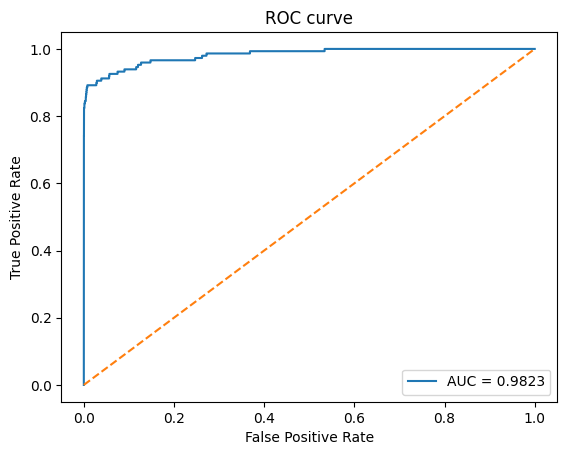

시간 : 48.81793475151062 sec
-----------------------------------------------------
model : LGBMClassifier()
real      0    1
pred            
0     85128  167
1        52   96
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.37      0.65      0.47       148

    accuracy                           1.00     85443
   macro avg       0.68      0.82      0.73     85443
weighted avg       1.00      1.00      1.00     85443



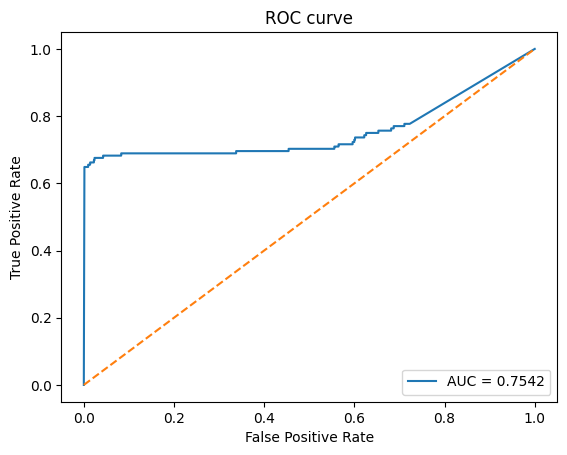

시간 : 5.849928617477417 sec
-----------------------------------------------------
model : DecisionTreeClassifier()
real      0    1
pred            
0     85267   28
1        37  111
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.80      0.75      0.77       148

    accuracy                           1.00     85443
   macro avg       0.90      0.87      0.89     85443
weighted avg       1.00      1.00      1.00     85443



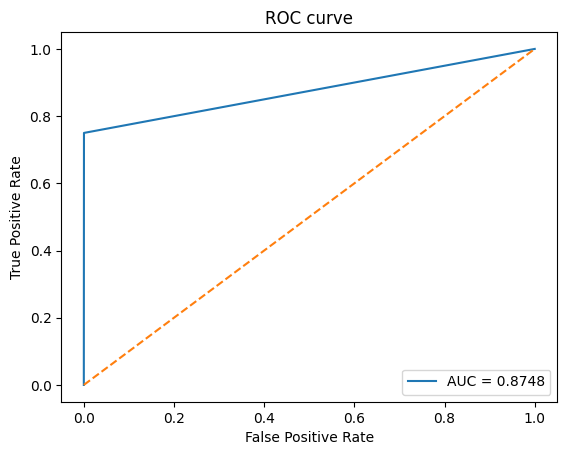

시간 : 18.55538535118103 sec
-----------------------------------------------------
model : RandomForestClassifier()
real      0    1
pred            
0     85291    4
1        43  105
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.71      0.82       148

    accuracy                           1.00     85443
   macro avg       0.98      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443



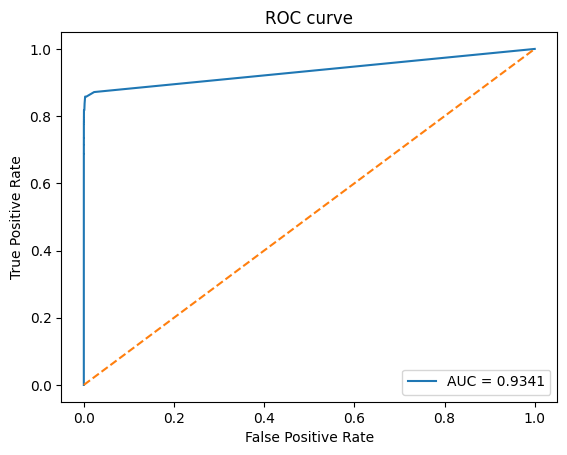

시간 : 195.39377546310425 sec
-----------------------------------------------------


In [39]:
# 모델 한꺼번에 돌리기

xgboost = XGBClassifier()
lightgbm = LGBMClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()

models = [xgboost, lightgbm, decisiontree, randomforest]

for i, model in enumerate(models):
#    print(model)
    get_model_train_eval(model, x_train, x_test, y_train, y_test)
    print('-----------------------------------------------------')

## **3. 언더 샘플링**

- 다수 범주의 데이터를 소수 범주의 데이터 수에 맞게 줄이는 샘플링 방식

### **3-1. 언더 샘플링 종류**

1. Random Under Sampling
- 다수 클래스에 속해 있는 데이터를 줄임
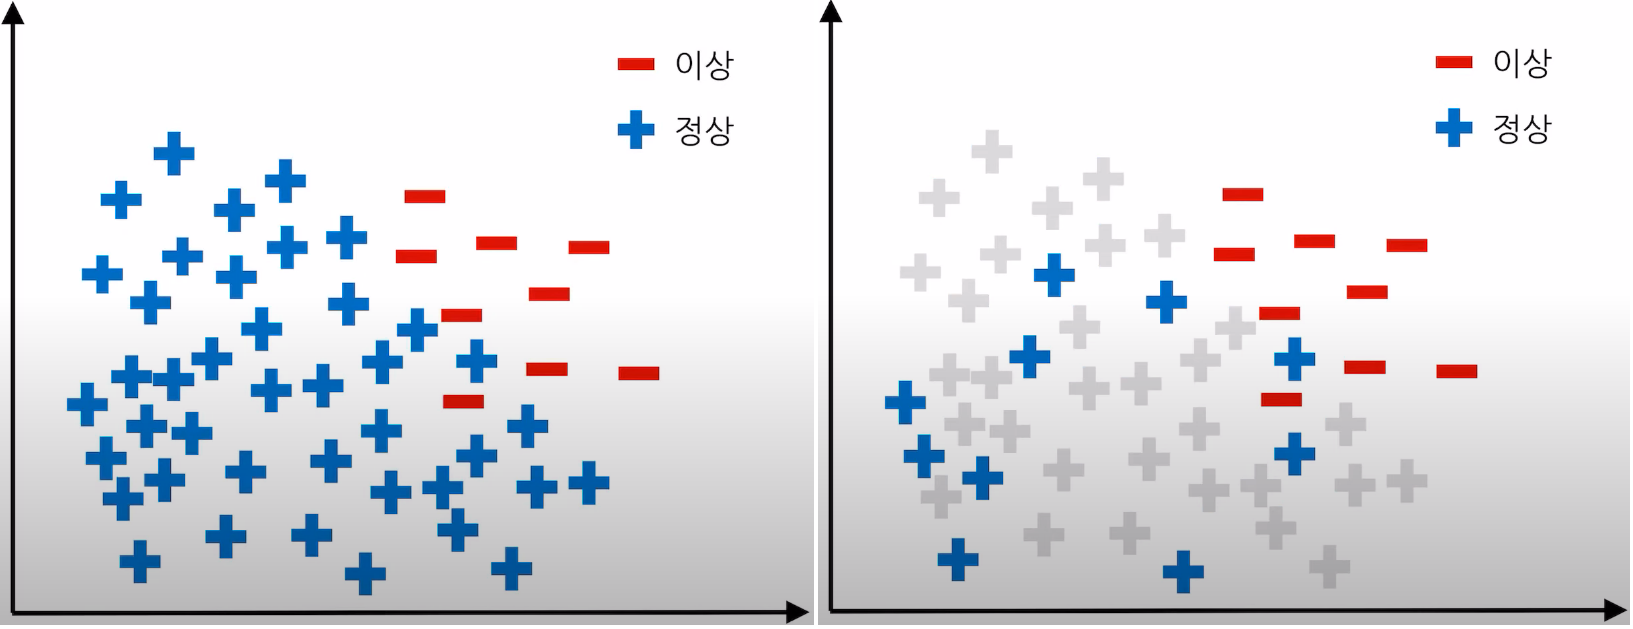



- 장점: 생각보다 성능 좋음
- 단점: 무작위로 샘플링 하기 때문에 할 때마다 다른 결과를 얻음 (random_state 미지정 시)

2. Tomek's link method

- 토멕링크(Tomek’s link)란 서로 다른 클래스에 속하는 한 쌍의 데이터 (x+,x−)로 서로에게 더 가까운 다른 데이터가 존재하지 않는 것이다. 즉 클래스가 다른 두 데이터가 아주 가까이 붙어있으면 토멕링크가 된다. 토멕링크 방법은 이러한 토멕링크를 찾은 다음 그 중에서 다수 클래스에 속하는 데이터를 제외하는 방법으로 경계선을 다수 클래스쪽으로 밀어붙이는 효과가 있다.

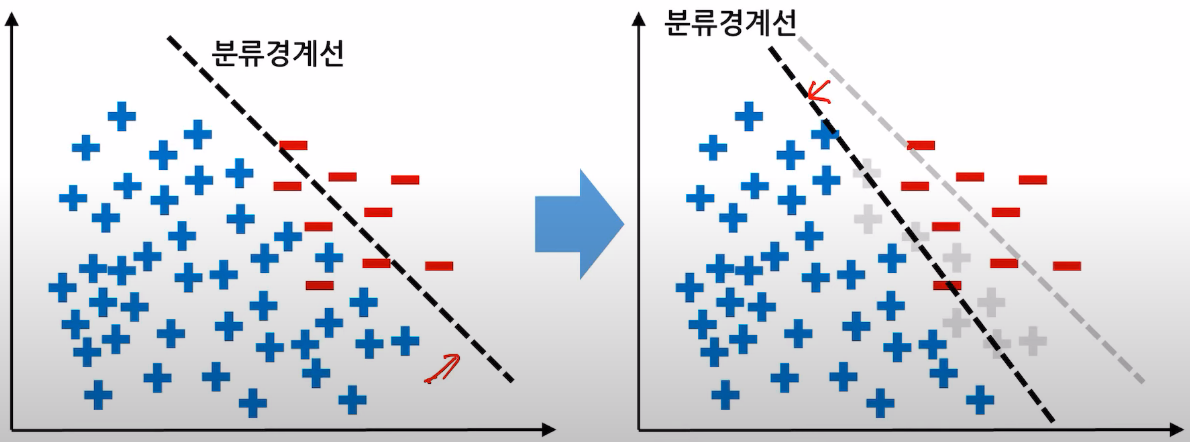

3. CNN (Condensed Nearest Neighbour)

- CNN(Condensed Nearest Neighbour) 방법은 1-NN 모형으로 분류되지 않는 데이터만 남기는 방법이다. 선텍된 데이터 집합을 S라고 하자.

    1. 소수 클래스 데이터를 모두 S에 포함시킨다.

    2. 다수 데이터 중에서 하나를 골라서 가장 가까운 데이터가 다수 클래스이면 포함시키지 않고 아니면 S에 포함시킨다.

    3. 더이상 선택되는 데이터가 없을 때까지 2를 반복한다.

- 이 방법을 사용하면 기존에 선택된 데이터와 가까이 있으면서 같은 클래스인 데이터는 선택되지 않기 때문에 다수 데이터의 경우 선택되는 비율이 적어진다.

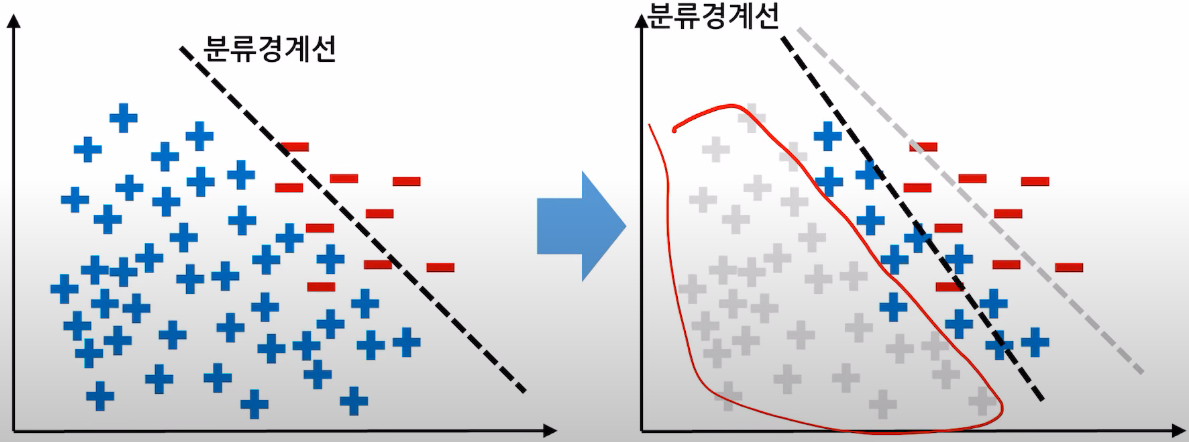

4. One sided Selection = Tomek's link + CNN

- One Sided Selection은 토맥링크 방법과 Condensed Nearest Neighbour 방법을 섞은 것이다. 토맥링크 중 다수 클래스를 제외하고 나머지 데이터 중에서도 서로 붙어있는 다수 클래스 데이터는 1-NN 방법으로 제외한다.

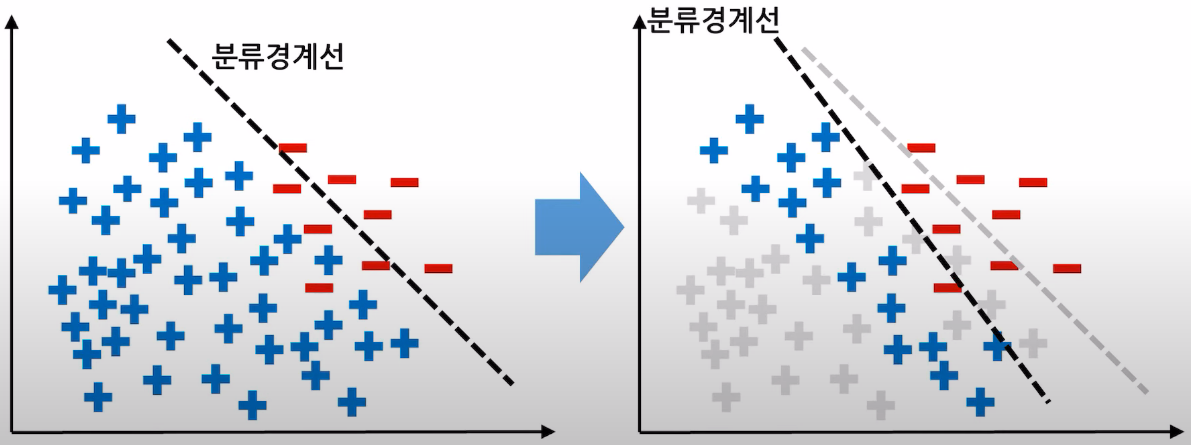

### **3-2. 언더샘플링 코드**

In [ ]:
# Random Under Sampling
X_samp, y_samp = RandomUnderSampler(random_state=0).fit_resample(x_train, y_train)

# Tomek's link method
X_samp, y_samp = TomekLinks(random_state=0).fit_resample(x_train, y_train)

# CNN (Condensed Nearest Neighbour)
X_samp, y_samp = CondensedNearestNeighbour(random_state=0).fit_resample(x_train, y_train)

# One sided Selection = Tomek's link + CNN
X_samp, y_samp = OneSidedSelection(random_state=0).fit_resample(x_train, y_train)

model : XGBClassifier()
real      0     1
pred             
0     81143  4152
1        13   135
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     85295
           1       0.03      0.91      0.06       148

    accuracy                           0.95     85443
   macro avg       0.52      0.93      0.52     85443
weighted avg       1.00      0.95      0.97     85443



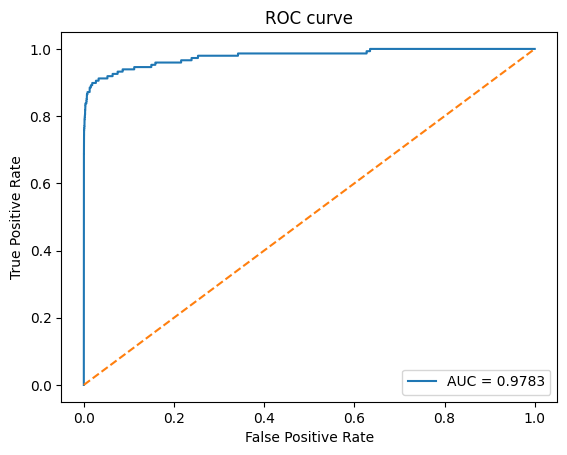

시간 : 1.136232852935791 sec
-----------------------------------------------------
model : LGBMClassifier()
real      0     1
pred             
0     81727  3568
1        15   133
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85295
           1       0.04      0.90      0.07       148

    accuracy                           0.96     85443
   macro avg       0.52      0.93      0.52     85443
weighted avg       1.00      0.96      0.98     85443



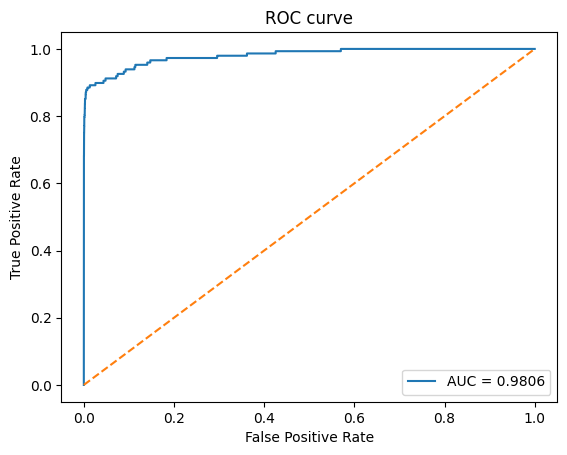

시간 : 2.1816253662109375 sec
-----------------------------------------------------
model : DecisionTreeClassifier()
real      0     1
pred             
0     76576  8719
1        10   138
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85295
           1       0.02      0.93      0.03       148

    accuracy                           0.90     85443
   macro avg       0.51      0.92      0.49     85443
weighted avg       1.00      0.90      0.94     85443



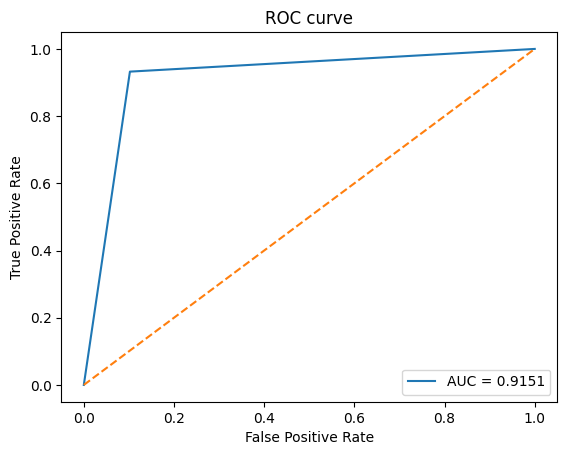

시간 : 0.42087745666503906 sec
-----------------------------------------------------
model : RandomForestClassifier()
real      0     1
pred             
0     82881  2414
1        17   131
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.89      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.97      0.98     85443



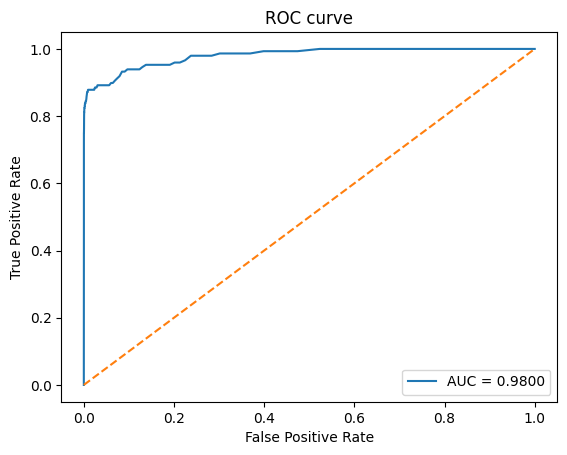

시간 : 2.1222312450408936 sec
-----------------------------------------------------


In [69]:
from imblearn.under_sampling import *

# Random Under Sampling

# fit_sample 에러나옴, fit_resample
# x_samp, y_samp = RandomUnderSampler(random_state=0).fit_sample(x_train, y_train)

x_samp, y_samp = RandomUnderSampler(random_state=0).fit_resample(x_train, y_train)

# 모델 한꺼번에 돌리기

xgboost = XGBClassifier()
lightgbm = LGBMClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()

models = [xgboost, lightgbm, decisiontree, randomforest]

for i, model in enumerate(models):
#    print(model)
    get_model_train_eval(model, x_samp, x_test, y_samp, y_test)
    print('-----------------------------------------------------')

### **3-3. 언더샘플링 장/단점**

- 장점 : 다수 클래스 데이터 제거로 계산 시간 감소
- 단점 : 데이터 제거로 인한 정보 손실 발생

## **4. 오버 샘플링**

### **4-1. 오버 샘플링 종류**

1. Random Over Sampling

- 소수 클래스에 속해 있는 데이터를 랜덤하게 늘림

2. ADASYN

- ADASYN(Adaptive Synthetic Sampling) 방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만드는 방법이다.

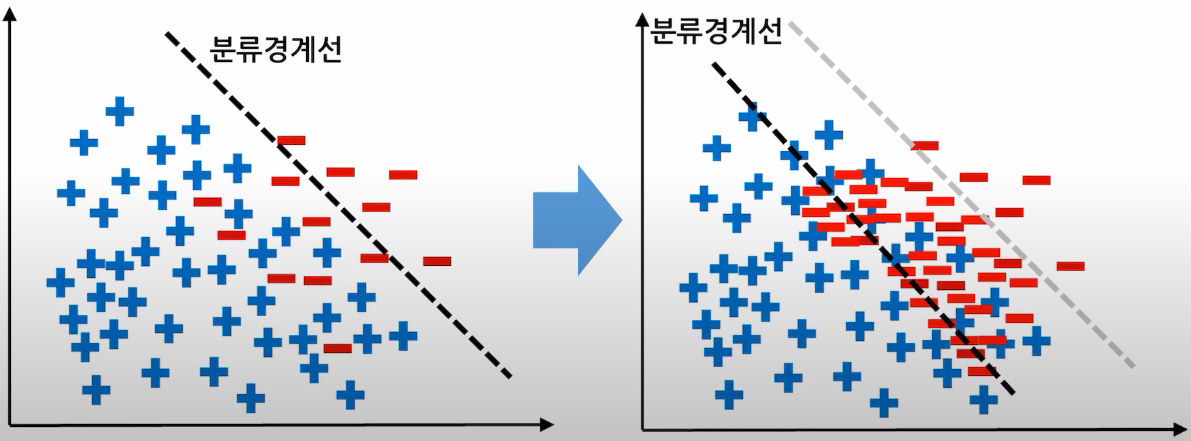

3. SMOTE

- SMOTE(Synthetic Minority Over-sampling Technique) 방법도 ADASYN 방법처럼 데이터를 생성하지만 생성된 데이터를 무조건 소수 클래스라고 하지 않고 분류 모형에 따라 분류한다.

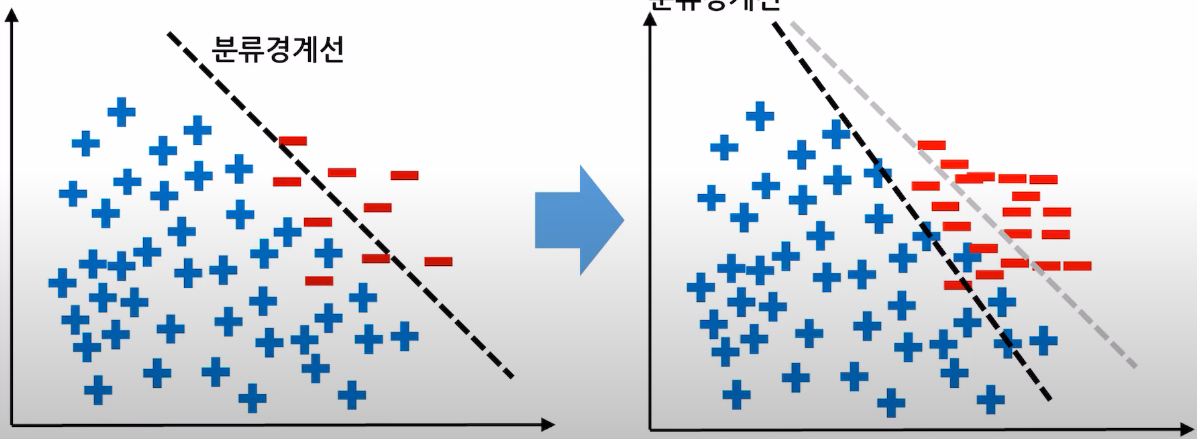

### **4-2. 오버샘플링 코드**

In [ ]:
# Random Over Sampling
X_samp, y_samp = RandomOverSampler(random_state=0).fit_resample(x_train, y_train)

# ADASYN (Adaptive Synthetic Sampling)
X_samp, y_samp = ADASYN(random_state=0).fit_resample(x_train, y_train)

# SMOTE (Synthetic Minority Over-sampling Technique)
X_samp, y_samp = SMOTE(random_state=0).fit_resample(x_train, y_train)

In [70]:
x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

model : XGBClassifier()
real      0    1
pred            
0     84842  453
1        22  126
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.22      0.85      0.35       148

    accuracy                           0.99     85443
   macro avg       0.61      0.92      0.67     85443
weighted avg       1.00      0.99      1.00     85443



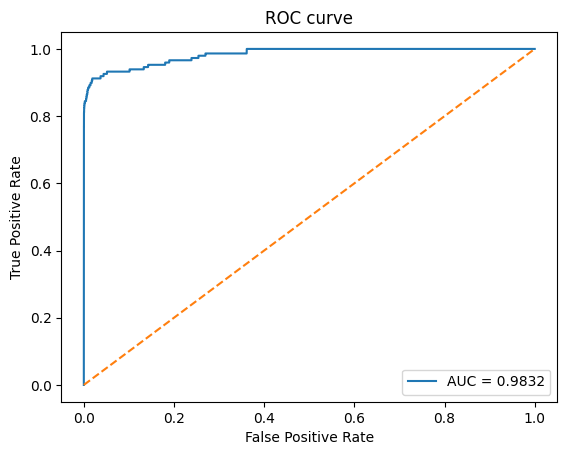

시간 : 109.36938238143921 sec
-----------------------------------------------------
model : LGBMClassifier()
real      0    1
pred            
0     85252   43
1        24  124
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.74      0.84      0.79       148

    accuracy                           1.00     85443
   macro avg       0.87      0.92      0.89     85443
weighted avg       1.00      1.00      1.00     85443



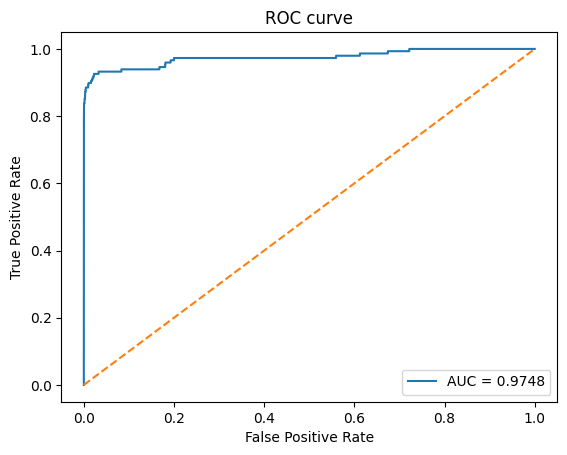

시간 : 13.135343074798584 sec
-----------------------------------------------------
model : DecisionTreeClassifier()
real      0    1
pred            
0     85143  152
1        42  106
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.41      0.72      0.52       148

    accuracy                           1.00     85443
   macro avg       0.71      0.86      0.76     85443
weighted avg       1.00      1.00      1.00     85443



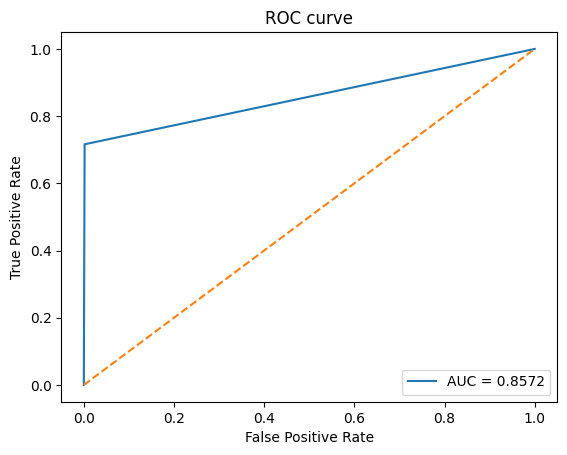

시간 : 52.012524127960205 sec
-----------------------------------------------------
model : RandomForestClassifier()
real      0    1
pred            
0     85284   11
1        30  118
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.80      0.85       148

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



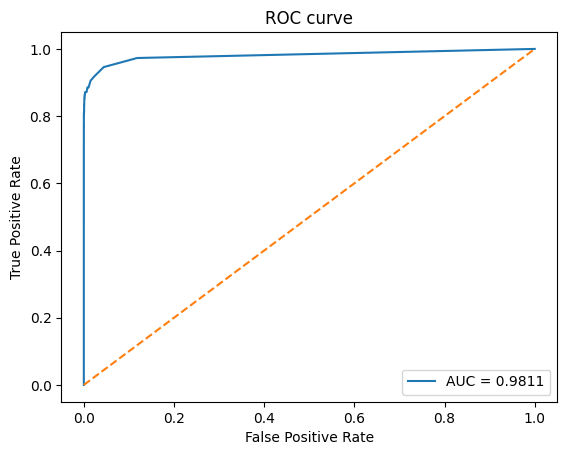

시간 : 358.6895339488983 sec
-----------------------------------------------------


In [71]:
# SMOTE (Synthetic Minority Over-sampling Technique)
x_samp, y_samp = SMOTE(random_state=0).fit_resample(x_train, y_train)

# 모델 한꺼번에 돌리기

xgboost = XGBClassifier()
lightgbm = LGBMClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()

models = [xgboost, lightgbm, decisiontree, randomforest]

for i, model in enumerate(models):
#    print(model)
    get_model_train_eval(model, x_samp, x_test, y_samp, y_test)
    print('-----------------------------------------------------')

### **4-3. 오버샘플링 장/단점**

- 장점 : 데이터 증가시키므로 정보 손실 없음 / 대부분 언더샘플링보다 높은 분류 정확도를 보임
- 단점 : 데이터 증가로 계산시간 증가 및 과적합 가능성 있음 / 노이즈 및 이상치에 민감함

## **5.복합 샘플링**

- SMOTE+Tomek 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 토멕링크 방법을 섞은 것이다.

model : XGBClassifier()
real      0    1
pred            
0     84877  418
1        21  127
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.23      0.86      0.37       148

    accuracy                           0.99     85443
   macro avg       0.62      0.93      0.68     85443
weighted avg       1.00      0.99      1.00     85443



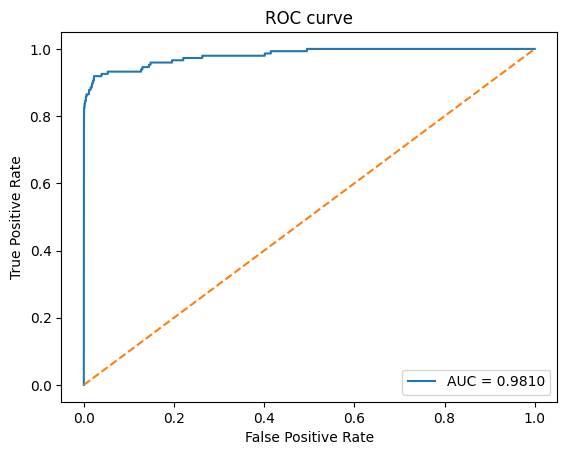

시간 : 100.64858627319336 sec
-----------------------------------------------------
model : LGBMClassifier()
real      0    1
pred            
0     85249   46
1        26  122
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.73      0.82      0.77       148

    accuracy                           1.00     85443
   macro avg       0.86      0.91      0.89     85443
weighted avg       1.00      1.00      1.00     85443



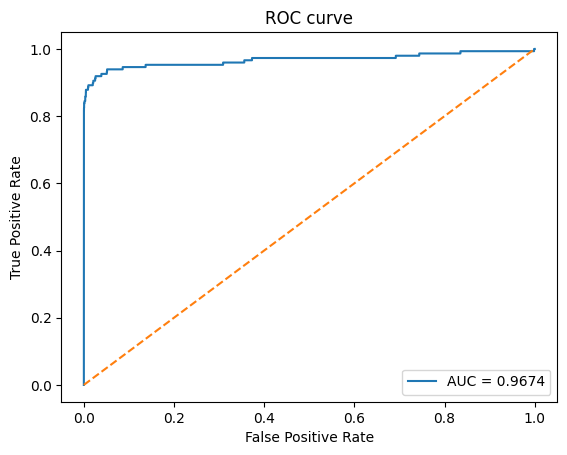

시간 : 12.305741310119629 sec
-----------------------------------------------------
model : DecisionTreeClassifier()
real      0    1
pred            
0     85146  149
1        31  117
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.44      0.79      0.57       148

    accuracy                           1.00     85443
   macro avg       0.72      0.89      0.78     85443
weighted avg       1.00      1.00      1.00     85443



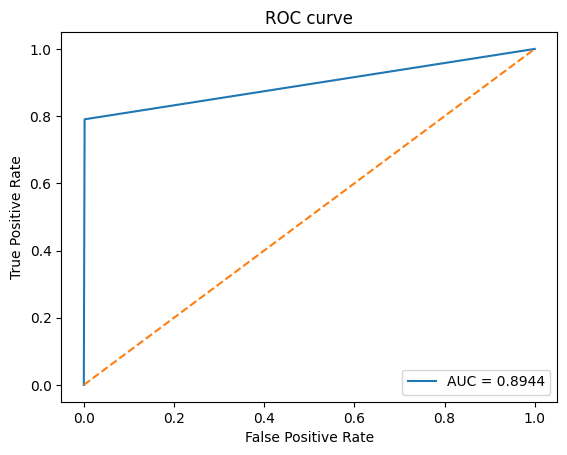

시간 : 37.907856464385986 sec
-----------------------------------------------------
model : RandomForestClassifier()
real      0    1
pred            
0     85280   15
1        29  119
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.80      0.84       148

    accuracy                           1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



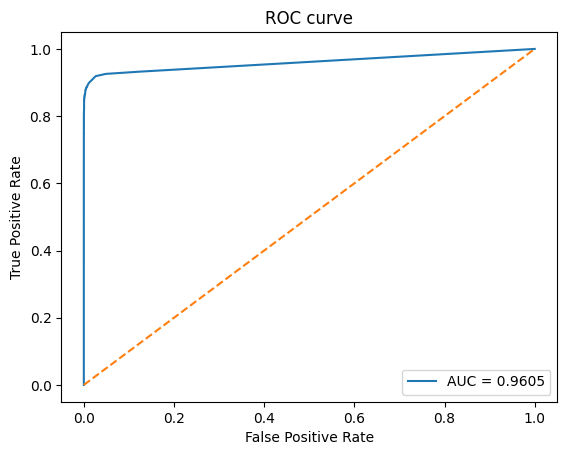

시간 : 309.52801156044006 sec
-----------------------------------------------------


In [73]:
x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)


from imblearn.combine import *

# Tomek's link + SMOTE
x_samp, y_samp = SMOTEENN(random_state=0).fit_resample(x_train, y_train)

# 모델 한꺼번에 돌리기

xgboost = XGBClassifier()
lightgbm = LGBMClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()

models = [xgboost, lightgbm, decisiontree, randomforest]

for i, model in enumerate(models):
#    print(model)
    get_model_train_eval(model, x_samp, x_test, y_samp, y_test)
    print('-----------------------------------------------------')

## **6. 출처**

이론
1. https://youtu.be/Vhwz228VrIk
2. https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html
3. https://casa-de-feel.tistory.com/15

실습
1. https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html
2. https://koreapy.tistory.com/728
3. https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7